# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Remark - 041_preprocessing ##

- Add calendar and review data to listing
- Do log(price)
- Do KNN clustering of location to replace zip code, longitude and latitude
- Add prior to the review scores


### Load listing data ###

In [2]:
import time
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from scipy.stats import mode
import goslate
from langdetect import detect
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib import colors
import matplotlib.dates as mdates
from datetime import datetime
from collections import Counter
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [5]:
# Load listing data
listing = pd.read_csv('../../Data/listings_clean.csv')
print(listing.columns.values)
print(listing.shape)
listing.head()

['id' 'host_since' 'zipcode' 'latitude' 'longitude' 'property_type'
 'room_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type'
 'guests_included' 'minimum_nights' 'maximum_nights' 'availability_30'
 'availability_60' 'availability_90' 'availability_365' 'number_of_reviews'
 'first_review' 'last_review' 'review_scores_rating'
 'review_scores_accuracy' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'review_scores_value' 'host_listing_count'
 'price']
(27392, 31)


,id,host_since,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,1926,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,...,2542.0,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160
1,1846722,1625,NaN,40.830599,-73.941014,0,0,10,1.0,3.0,...,2554.0,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,105
2,2061725,1831,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,...,2554.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58
3,44974,953,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,...,2494.0,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185
4,4701675,2479,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,...,2533.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195


In [6]:
# read data
calendar = pd.read_csv('../../Data/calendar_grid.csv', delimiter = ',')

# check data
print(calendar.shape)
calendar.head(n=10)

(27392, 366)


,listing_id,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,...,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31
0,3604481,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,...,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
1,2949128,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,4325397,100.0,100.0,100.0,100.0,100.0,70.0,70.0,70.0,80.0,...,70.0,70.0,70.0,80.0,80.0,70.0,70.0,70.0,70.0,70.0
3,4325398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0,275.0
4,3426149,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN,...,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0
5,65562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
6,2730672,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
7,4587554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0
8,819206,NaN,NaN,NaN,70.0,70.0,70.0,70.0,70.0,70.0,...,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
9,4849703,NaN,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Get price info from calendar
calendar_np = calendar.values
calendar_np = np.delete(calendar_np, 0, axis=1)

# Get datetime format of calendar
col_idx = calendar.columns.values
col_idx = col_idx[1:]
datetime_all = []
for idx in range(col_idx.shape[0]):
   datetime_all.append(datetime.strptime('2015-' + col_idx[idx], '%Y-%m-%d'))

In [12]:
int(datetime_all[31].strftime("%m"))

2

In [17]:
# Get days in each month
month_code = np.empty(col_idx.shape[0])
for idx in range(col_idx.shape[0]):
    month_code[idx] = int(datetime_all[idx].strftime("%m"))

In [23]:
calendar_coded = pd.DataFrame(calendar['listing_id'])
calendar_coded.head()

,listing_id
0,3604481
1,2949128
2,4325397
3,4325398
4,3426149


In [24]:
m_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for m_idx in range(12):
    tmp = np.nanmean(calendar_np[:,month_code==m_idx+1], axis=1)
    calendar_coded[m_list[m_idx]]=pd.Series(tmp, index=calendar_coded.index)

In [27]:
calendar_coded[40:60]

,listing_id,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
40,4587696,110.000000,110.000000,110.000000,110.0,110.000000,110.0,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
41,3539121,101.666667,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
42,4849849,95.000000,92.857143,91.612903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,1704132,41.428571,50.000000,64.193548,65.0,65.000000,65.0,65.000000,65.000000,NaN,NaN,NaN,NaN
44,3276997,119.000000,119.000000,NaN,129.0,139.000000,NaN,NaN,NaN,NaN,114.714286,114.333333,114.161290
45,262343,135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,4795088,112.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,4325606,170.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.000000,239.000000
48,917739,400.000000,400.000000,400.000000,400.0,400.000000,400.0,400.000000,400.000000,400.000000,NaN,400.000000,400.000000
49,1573110,110.000000,NaN,NaN,NaN,NaN,NaN,NaN,85.333333,85.333333,86.451613,85.333333,85.161290


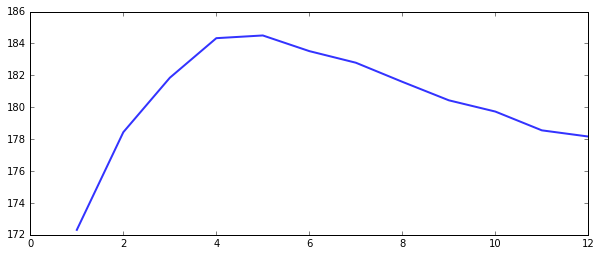

In [31]:
# Get price info from calendar
test = calendar_coded.values
test = np.delete(test, 0, axis=1)
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 4))
ax6.plot(range(1,13,1),np.nanmean(test,axis=0), c='blue', label='price', linewidth=2.0, alpha = 0.8)

In [33]:
xx=np.nanmean(test,axis=0)
print np.max(xx)/np.min(xx)

1.07076977234
